In [1]:
import os
import numpy as np
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
import cv2
import json
from sklearn.model_selection import train_test_split

In [2]:
labels = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/types.npy')
images = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Images/images.npy',allow_pickle=True)
masks = np.load('../input/cancer-inst-segmentation-and-classification/Part 1/Masks/masks.npy',allow_pickle=True)

images = images.astype(np.int16)
masks = masks.astype(np.int16)

print(labels.shape)
print(images.shape)
print(masks.shape)

(2656,)
(2656, 256, 256, 3)
(2656, 256, 256, 6)


In [3]:
nuclei_names = ["neoplastic","inflammatory","softtissue","dead","epithelial"]

In [4]:
tissue_names = np.unique(labels, return_counts=False)

In [5]:
  def create_bboxes(image_id,mask_id,masks):
    # Load the binary mask image
    mask = masks[image_id,:,:,mask_id]

    # Label the connected components in the mask
    label_mask = label(mask)

    # Extract the bounding box coordinates for each object
    bboxes = []
    for region in regionprops(label_mask):
        minr, minc, maxr, maxc = region.bbox
        bbox = [minr, minc, maxr , maxc]
        bboxes.append(bbox)
    return bboxes

In [6]:
def iscrowd_from_object(bbox, area):
    if area < 100 or bbox[0] > 500 or bbox[1] > 500:
        return 0
    else:
        return 1

In [7]:
# Get the file path
file_path = 'pan-nuclei-cancer.json'

def get_coco_json(file_path,index,images,labels,masks,nuclei_names):
    # Create a dictionary to store the COCO-formatted data
    coco_data = {
        "images": [],
        "annotations": [],
        "categories": []
    }

    # Add the annotation information to the "annotations" list
    annotation_id = 0
    for image_id in index:
        for mask_id,mask in enumerate(nuclei_names):
            bboxes = create_bboxes(image_id,mask_id,masks)
            for bbox_id,bbox in enumerate(bboxes):
                area = bbox[2]* bbox[3]  #area = width * height
                iscrowd = iscrowd_from_object(bbox, area) 
                coco_data["annotations"].append({
                        "id": annotation_id,
                        "image_id": image_id,
                        "category_id": mask_id,
                        "bbox": bbox,
                        "area": area,
                        "iscrowd": iscrowd
                    })
                annotation_id += 1
                
    # Add the image information to the "images" list
    for i in index:
        coco_data["images"].append({
            "id": i,
            "file_name": labels[i]
        })

    # Add the category information to the "categories" list
    for i, name in enumerate(nuclei_names):
        coco_data["categories"].append({
            "id": i,
            "name": name
        })

    # Save the COCO-formatted data to a JSON file
    with open(file_path, 'w') as f:
        json.dump(coco_data, f)

In [8]:
#delete image with no nuclei
def clear_data(index,nuclei_names):
    index_clear = []
    for image_id in range(len(index)):
        box = []
        for mask_id,mask in enumerate(nuclei_names):
            box.append(create_bboxes(image_id,mask_id,masks))
        if (box!=[[],[],[],[],[]]):
            index_clear.append(image_id)
    return index_clear

In [9]:
index = [i for i in range(0,images.shape[0])]
clear_index = clear_data(index,nuclei_names)
clear_labels = [labels[i] for i in clear_index ]


In [10]:
get_coco_json(file_path,clear_index,images,labels,masks,nuclei_names)

Now, we are able to convert our data to the good format. However, it seems easier to split before the data into train and test set and then convert each one in coco format. So let's do this.

In [11]:
LABEL_ID_MAP = {label: i for i, label in enumerate(clear_labels)}
y = np.array([LABEL_ID_MAP[label] for label in clear_labels])

In [12]:
# split data into training and test sets
Index_train, Index_test, y_train, y_test = train_test_split(clear_index, y, test_size=0.2, random_state=42)

In [13]:
file_path = 'train-pan-nuclei-cancer.json'
get_coco_json(file_path,Index_train,images,labels,masks,nuclei_names)

file_path = 'test-pan-nuclei-cancer.json'
get_coco_json(file_path,Index_test,images,labels,masks,nuclei_names)

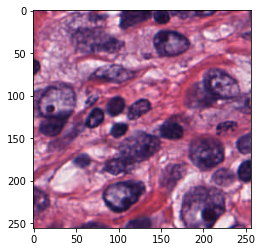

In [16]:
idx = Index_train[0]
img = images[idx]
plt.imshow(img.astype(int))

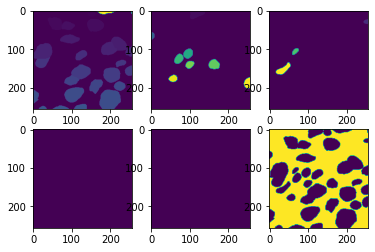

In [17]:
for i in range(6):
        plt.subplot(2, 3, i+1)

        mask = masks[idx, :, :, i]  
        plt.imshow(mask)

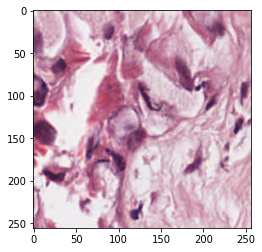

In [18]:
idx = Index_test[0]
img = images[idx]
plt.imshow(img.astype(int))

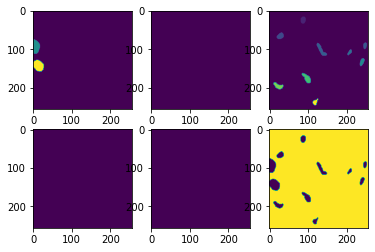

In [19]:
for i in range(6):
        plt.subplot(2, 3, i+1)

        mask = masks[idx, :, :, i]  
        plt.imshow(mask)